# Transfer Learning with EfficientNetV2-S (PyTorch)

## 1. Imports, seeds and paths

In [5]:
import os
import sys
import random
import time
from pathlib import Path
import glob

import numpy as np
import pandas as pd

cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    normalize_splits,
    format_duration,
    build_classification_report,
    compute_classification_metrics,
    compute_confusion_matrix,
    log_metrics_to_csv,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

# Fallback for mixed TF/PyTorch CUDA environments in WSL:
# expose CUDA/cuDNN libs from the dedicated PyTorch venv before importing torch
torch_venv = Path('/home/user/venvs/cifar10-torch')
if torch_venv.exists():
    py_ver = f"python{sys.version_info.major}.{sys.version_info.minor}"
    torch_site = torch_venv / 'lib' / py_ver / 'site-packages'
    nvidia_lib_dirs = glob.glob(str(torch_site / 'nvidia' / '*' / 'lib'))
    wsl_lib = '/usr/lib/wsl/lib'
    parts = [wsl_lib] + nvidia_lib_dirs
    existing = os.environ.get('LD_LIBRARY_PATH', '')
    if existing:
        parts.append(existing)
    os.environ['LD_LIBRARY_PATH'] = ':'.join(parts)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import EfficientNet_V2_S_Weights

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'Python executable: {sys.executable}')
print(f'Torch version: {torch.__version__}')
print(f'Torch path: {torch.__file__}')
print(f'Torch CUDA runtime: {torch.version.cuda}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
else:
    print('CUDA not available in current kernel. Select kernel: cifar10-torch (PyTorch).')

Using device: cuda
Python executable: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/.venv/bin/python
Torch version: 2.10.0+cu128
Torch path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/.venv/lib/python3.12/site-packages/torch/__init__.py
Torch CUDA runtime: 12.8
GPU: NVIDIA GeForce RTX 4060 Ti


In [7]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.lower() != 'cifar10_project' and (PROJECT_ROOT / 'cifar10_project').is_dir():
    PROJECT_ROOT = PROJECT_ROOT / 'cifar10_project'

DATA_DIR = PROJECT_ROOT / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
REPORTS_DIR = PROJECT_ROOT / 'reports'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

data_path = PROCESSED_DIR / 'cifar10_processed.npz'
performance_report_path = DATA_DIR / 'model_performance_report.csv'

print('Data path:', data_path)
print('Performance report path:', performance_report_path)

Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz
Performance report path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/model_performance_report.csv


## 2. Load processed data

In [8]:
data = np.load(data_path)

x_train = data['x_train'].astype(np.float32)
y_train = np.squeeze(data['y_train']).astype(np.int64)
x_val = data['x_val'].astype(np.float32)
y_val = np.squeeze(data['y_val']).astype(np.int64)
x_test = data['x_test'].astype(np.float32)
y_test = np.squeeze(data['y_test']).astype(np.int64)

#splits = normalize_splits({
#    'x_train': x_train,
#    'x_val': x_val,
#    'x_test': x_test,
#}, scale=255.0, dtype='float32', clip_range=(0.0, 1.0))
#x_train, x_val, x_test = splits['x_train'], splits['x_val'], splits['x_test']

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

print('Train:', x_train.shape, y_train.shape)
print('Val:  ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)

Train: (40000, 32, 32, 3) (40000,)
Val:   (10000, 32, 32, 3) (10000,)
Test:  (10000, 32, 32, 3) (10000,)


## 3. Data pipeline with resizing to 96x96

In [29]:
IMG_SIZE = 96
BATCH_SIZE = 64
NUM_WORKERS = 2

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(
        size=IMG_SIZE,
        scale=(0.85, 1.0),
        ratio=(1.0, 1.0),
    ),
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.04,
    ),
    transforms.Lambda(lambda x: torch.clamp(x, 0.0, 1.0)),
    transforms.Normalize(mean=mean, std=std),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize(mean=mean, std=std),
])

class CifarArrayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).permute(2, 0, 1).float()
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

train_ds = CifarArrayDataset(x_train, y_train, transform=train_transform)
val_ds = CifarArrayDataset(x_val, y_val, transform=eval_transform)
test_ds = CifarArrayDataset(x_test, y_test, transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(train_loader))
print('Batch shape:', xb.shape, yb.shape)

Batch shape: torch.Size([64, 3, 96, 96]) torch.Size([64])


## 4. Build EfficientNetV2-S transfer learning model

In [10]:
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_s(weights=weights)

for param in model.features.parameters():
    param.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


## 5. Train helpers

In [30]:
from sched import scheduler


def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(images)
            loss = criterion(logits, labels)
            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    return epoch_loss, epoch_acc


def fit_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience, stage_name):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = -1.0
    best_state = None
    best_epoch = 0
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer=None)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_acc)
        else:
            scheduler.step()  

        print(f'[{stage_name}] Epoch {epoch:03d}/{epochs} | '
              f'train_loss={train_loss:.4f} train_acc={train_acc:.4f} | '
              f'val_loss={val_loss:.4f} val_acc={val_acc:.4f} lr={optimizer.param_groups[0]["lr"]:.6f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            best_epoch = epoch
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'[{stage_name}] Early stopping triggered.')
                print(f'[{stage_name}] Best val_acc={best_val_acc:.4f} at epoch {best_epoch:03d}.')
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        restored_val_loss, restored_val_acc = run_epoch(model, val_loader, criterion, optimizer=None)
        print(f'[{stage_name}] Restored -> val_acc={restored_val_acc:.4f}')

    return history

## 6. Stage 1 training (feature extraction)

In [21]:
epochs_stage1 = 30
initial_lr = 1e-3

criterion_stage1 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_stage1 = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=initial_lr)
scheduler_stage1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_stage1, mode='max', factor=0.5, patience=3, min_lr=1e-6
)

train_start_time = time.time()
history_stage1 = fit_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_stage1,
    optimizer=optimizer_stage1,
    scheduler=scheduler_stage1,
    epochs=epochs_stage1,
    patience=4,
    stage_name='stage1'
)

[stage1] Epoch 001/30 | train_loss=0.7640 train_acc=0.8964 | val_loss=0.7311 val_acc=0.9029 lr=0.001000
[stage1] Epoch 002/30 | train_loss=0.6875 train_acc=0.9235 | val_loss=0.7033 val_acc=0.9129 lr=0.001000
[stage1] Epoch 003/30 | train_loss=0.6571 train_acc=0.9362 | val_loss=0.7944 val_acc=0.8753 lr=0.001000
[stage1] Epoch 004/30 | train_loss=0.6385 train_acc=0.9437 | val_loss=0.6777 val_acc=0.9270 lr=0.001000
[stage1] Epoch 005/30 | train_loss=0.6211 train_acc=0.9516 | val_loss=0.6786 val_acc=0.9248 lr=0.001000
[stage1] Epoch 006/30 | train_loss=0.6102 train_acc=0.9562 | val_loss=0.6695 val_acc=0.9310 lr=0.001000
[stage1] Epoch 007/30 | train_loss=0.6016 train_acc=0.9596 | val_loss=0.6585 val_acc=0.9351 lr=0.001000
[stage1] Epoch 008/30 | train_loss=0.5922 train_acc=0.9634 | val_loss=0.6727 val_acc=0.9307 lr=0.001000
[stage1] Epoch 009/30 | train_loss=0.5842 train_acc=0.9668 | val_loss=0.6707 val_acc=0.9315 lr=0.001000
[stage1] Epoch 010/30 | train_loss=0.5792 train_acc=0.9689 | val

## 7. Stage 2 training (fine-tuning)

In [31]:
for param in model.features.parameters():
    param.requires_grad = True

fine_tune_at = len(model.features) // 2
for block_idx, block in enumerate(model.features):
    if block_idx < fine_tune_at:
        for param in block.parameters():
            param.requires_grad = False

epochs_stage2 = 80
fine_tune_lr = 1e-4

criterion_stage2 = nn.CrossEntropyLoss(label_smoothing=0.10)
optimizer_stage2 = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=fine_tune_lr)
scheduler_stage2 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_stage2, T_max=epochs_stage2, eta_min=1e-9
)

history_stage2 = fit_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_stage2,
    optimizer=optimizer_stage2,
    scheduler=scheduler_stage2,
    epochs=epochs_stage2,
    patience=8,
    stage_name='stage2'
)

train_duration_sec = time.time() - train_start_time
print(f'Training time: {train_duration_sec:.2f} sec')

[stage2] Epoch 001/80 | train_loss=0.5213 train_acc=0.9923 | val_loss=0.6169 val_acc=0.9555 lr=0.000100
[stage2] Epoch 002/80 | train_loss=0.5205 train_acc=0.9924 | val_loss=0.6150 val_acc=0.9581 lr=0.000100
[stage2] Epoch 003/80 | train_loss=0.5185 train_acc=0.9932 | val_loss=0.6195 val_acc=0.9566 lr=0.000100
[stage2] Epoch 004/80 | train_loss=0.5193 train_acc=0.9930 | val_loss=0.6185 val_acc=0.9563 lr=0.000099
[stage2] Epoch 005/80 | train_loss=0.5176 train_acc=0.9936 | val_loss=0.6161 val_acc=0.9584 lr=0.000099
[stage2] Epoch 006/80 | train_loss=0.5161 train_acc=0.9943 | val_loss=0.6183 val_acc=0.9583 lr=0.000099
[stage2] Epoch 007/80 | train_loss=0.5167 train_acc=0.9941 | val_loss=0.6176 val_acc=0.9574 lr=0.000098
[stage2] Epoch 008/80 | train_loss=0.5155 train_acc=0.9947 | val_loss=0.6158 val_acc=0.9581 lr=0.000098
[stage2] Epoch 009/80 | train_loss=0.5142 train_acc=0.9950 | val_loss=0.6178 val_acc=0.9575 lr=0.000097
[stage2] Epoch 010/80 | train_loss=0.5132 train_acc=0.9954 | val

## 8. Evaluation, plots and logging

In [32]:
def merge_histories(h1, h2):
    out = {}
    for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
        out[key] = h1.get(key, []) + h2.get(key, [])
    return out


def predict_loader(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            logits = model(images)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(labels.numpy().tolist())
    return np.array(y_true), np.array(y_pred)

EfficientNetV2-S test accuracy: 0.9555
Classification Report (EfficientNetV2-S):
              precision    recall  f1-score   support

    airplane     0.9616    0.9760    0.9687      1000
  automobile     0.9760    0.9770    0.9765      1000
        bird     0.9516    0.9440    0.9478      1000
         cat     0.9145    0.8880    0.9011      1000
        deer     0.9524    0.9610    0.9567      1000
         dog     0.9061    0.9170    0.9115      1000
        frog     0.9730    0.9740    0.9735      1000
       horse     0.9760    0.9770    0.9765      1000
        ship     0.9654    0.9770    0.9712      1000
       truck     0.9777    0.9640    0.9708      1000

    accuracy                         0.9555     10000
   macro avg     0.9554    0.9555    0.9554     10000
weighted avg     0.9554    0.9555    0.9554     10000



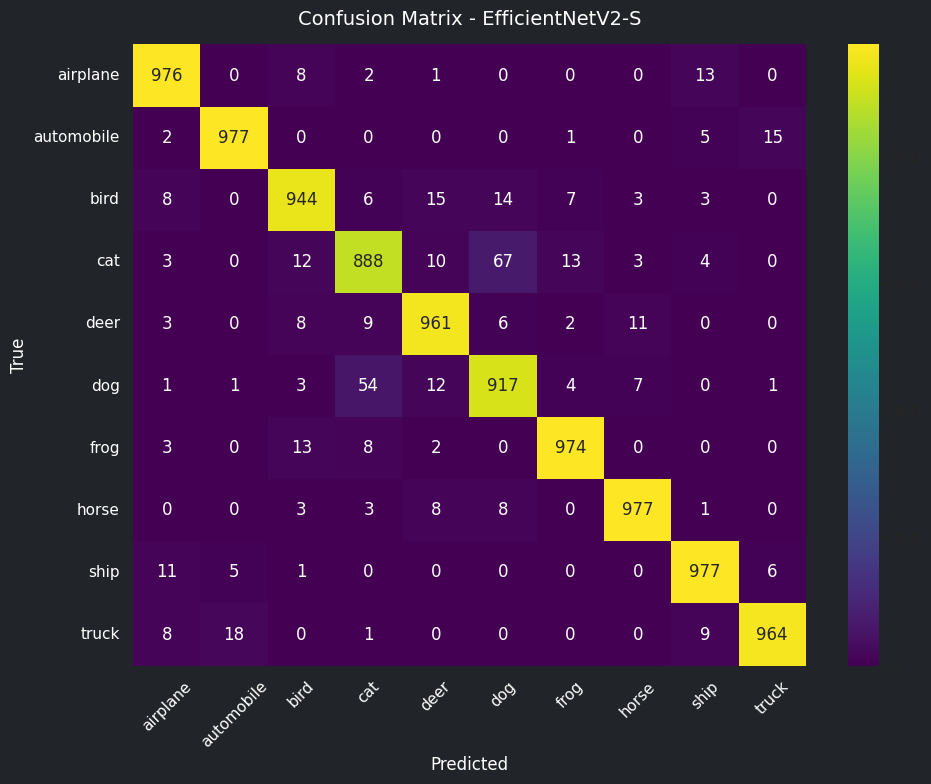

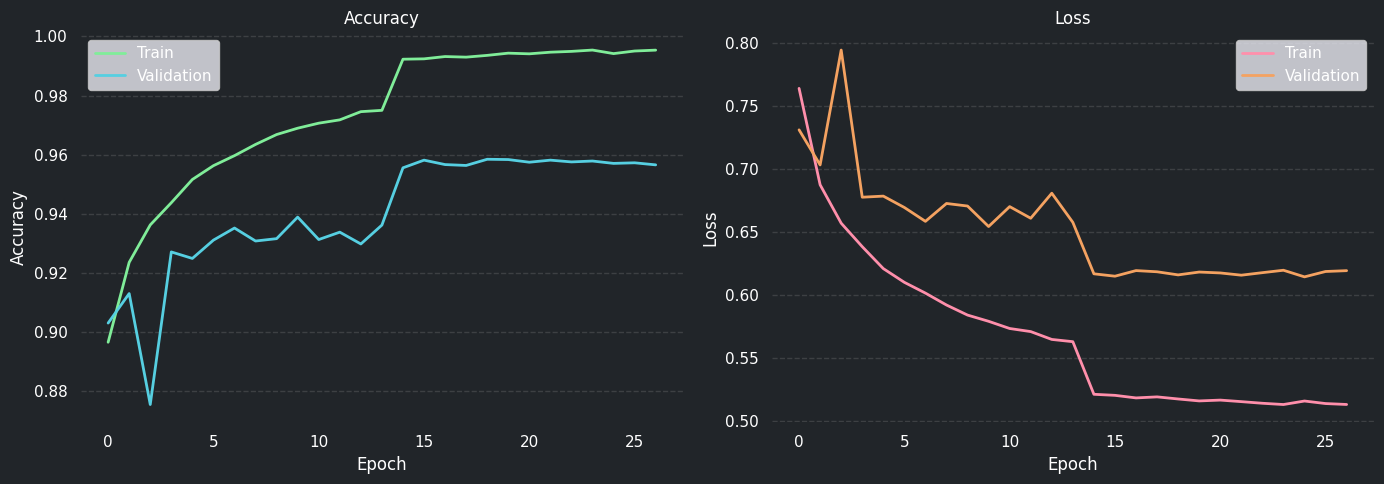

Logged metrics: {'model_name': 'EfficientNetV2S Transfer Learning (PyTorch)', 'num_params': 20190298, 'train_time_sec': 3020.15, 'train_time': '50 min 20 sec', 'timestamp': '2026-02-20 22:18', 'accuracy': 0.9555, 'precision': 0.9554442570666956, 'recall': 0.9555, 'f1': 0.9554322056008651, 'support': 10000, 'final_accuracy': 0.995375, 'final_loss': 0.5132498963356018, 'final_val_accuracy': 0.9565, 'final_val_loss': 0.6194146751403808, 'final_learning_rate': 9.362486410563633e-05, 'epochs_trained': 27, 'test_loss': 0.2244143312931061, 'framework': 'pytorch'}
Saved model to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/efficientnetv2s_cifar10_tuned.pt
Saved confusion matrix to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/efficientnetv2s_confusion.png
Saved curves to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScie

In [33]:
try:
    build_classification_report
    compute_classification_metrics
    compute_confusion_matrix
    log_metrics_to_csv
    plot_confusion_matrix_notebook01
    plot_training_curves_notebook01
    format_duration
except NameError:
    import sys
    from pathlib import Path

    cwd = Path.cwd()
    if cwd.name.lower() == "notebooks":
        project_root = cwd.parent
    elif cwd.name.lower() == "cifar10_project":
        project_root = cwd
    elif (cwd / "cifar10_project").is_dir():
        project_root = cwd / "cifar10_project"
    else:
        project_root = None

    if project_root is not None and str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))

    from utils.ml_utils import (
        build_classification_report,
        compute_classification_metrics,
        compute_confusion_matrix,
        log_metrics_to_csv,
        plot_confusion_matrix_notebook01,
        plot_training_curves_notebook01,
        format_duration,
    )

test_loss, test_acc = run_epoch(model, test_loader, nn.CrossEntropyLoss(), optimizer=None)
print(f'EfficientNetV2-S test accuracy: {test_acc:.4f}')

y_true, y_pred = predict_loader(model, test_loader)
print('Classification Report (EfficientNetV2-S):')
print(build_classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = compute_confusion_matrix(y_true, y_pred)
conf_path = REPORTS_DIR / 'efficientnetv2s_confusion.png'
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix - EfficientNetV2-S',
    save_path=conf_path,
    dpi=300,
 )

history_all = merge_histories(history_stage1, history_stage2)
curves_path = REPORTS_DIR / 'efficientnetv2s_curves.png'
plot_training_curves_notebook01(
    history=history_all,
    save_path=curves_path,
    dpi=300,
 )

metrics = compute_classification_metrics(y_true, y_pred, average='macro')
epochs_done = len(history_all['accuracy'])
num_params = int(sum(p.numel() for p in model.parameters()))

final_lr = None
for group in optimizer_stage2.param_groups:
    final_lr = float(group['lr'])
    break

row = {
    'model_name': 'EfficientNetV2S Transfer Learning (PyTorch)',
    'num_params': num_params,
    'train_time_sec': float(round(train_duration_sec, 2)),
    'train_time': format_duration(train_duration_sec),
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
    'accuracy': float(metrics['accuracy']),
    'precision': float(metrics['precision']),
    'recall': float(metrics['recall']),
    'f1': float(metrics['f1']),
    'support': int(metrics['support']),
    'final_accuracy': float(history_all['accuracy'][-1]) if history_all['accuracy'] else None,
    'final_loss': float(history_all['loss'][-1]) if history_all['loss'] else None,
    'final_val_accuracy': float(history_all['val_accuracy'][-1]) if history_all['val_accuracy'] else None,
    'final_val_loss': float(history_all['val_loss'][-1]) if history_all['val_loss'] else None,
    'final_learning_rate': final_lr,
    'epochs_trained': int(epochs_done),
    'test_loss': float(test_loss),
    'framework': 'pytorch',
}

_ = log_metrics_to_csv(performance_report_path, row, append=True)
print('Logged metrics:', row)

model_path = MODELS_DIR / "efficientnetv2s_cifar10_tuned.pt"

ckpt = {
  "arch": "efficientnet_v2_s",
  "weights_enum": "IMAGENET1K_V1",
  "img_size": 96,
  "mean": [0.485, 0.456, 0.406],
  "std":  [0.229, 0.224, 0.225],
  "class_names": class_names,
  "model_state_dict": model.state_dict(),
}
torch.save(ckpt, model_path)

print('Saved model to:', model_path)
print('Saved confusion matrix to:', conf_path)
print('Saved curves to:', curves_path)

target = 0.97
if metrics['accuracy'] >= target:
    print('Target reached: >= 97% accuracy ✅')
else:
    print(f"Target not reached yet: {metrics['accuracy']:.4%} < {target:.0%}")